# CAB420, Practical 6 - Question 1
## Eigenfaces

Consider the EigenFaces example from the lecture (``CAB420_Dimension_Reduction_Example_5_Eigenfaces.ipynb``). Using this example, and the PCA space that is learned on the YaleB Face Dataset, investigate the face recognition performance of two additional datasets:
* Yale_32x32.mat; and
* ORL_32x32.mat. 

For each of these you should:
* Use the PCA space learned on the YaleB data (i.e. don't learn a different PCA space on the new data);
* Ensure that the new data is resized to the same size as the YaleB data prior to use;
* Train a simple KNN classifier, using roughly 66\% of the data as training, and the rest as testing;
* Evaluate the accuracy of the predictions with different numbers of components retained;
* Visually inspect reconstructions with different numbers of components retained, and comment on the quality of the reconstructions for the two databases.

### Relevant Examples

The eigenfaces example, ``CAB420_Dimension_Reduction_Example_5_Eigenfaces.ipynb`` is the key example here.

### Suggested Packages

It's sklearn again in this one.

In [1]:
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

### Part 1: Preliminaries
Load data, compute PCA space, etc.

This is an abbreviated version of the lecture example.

In [25]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

In [26]:
pca = decomposition.PCA()
pca.fit(train_fea)
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

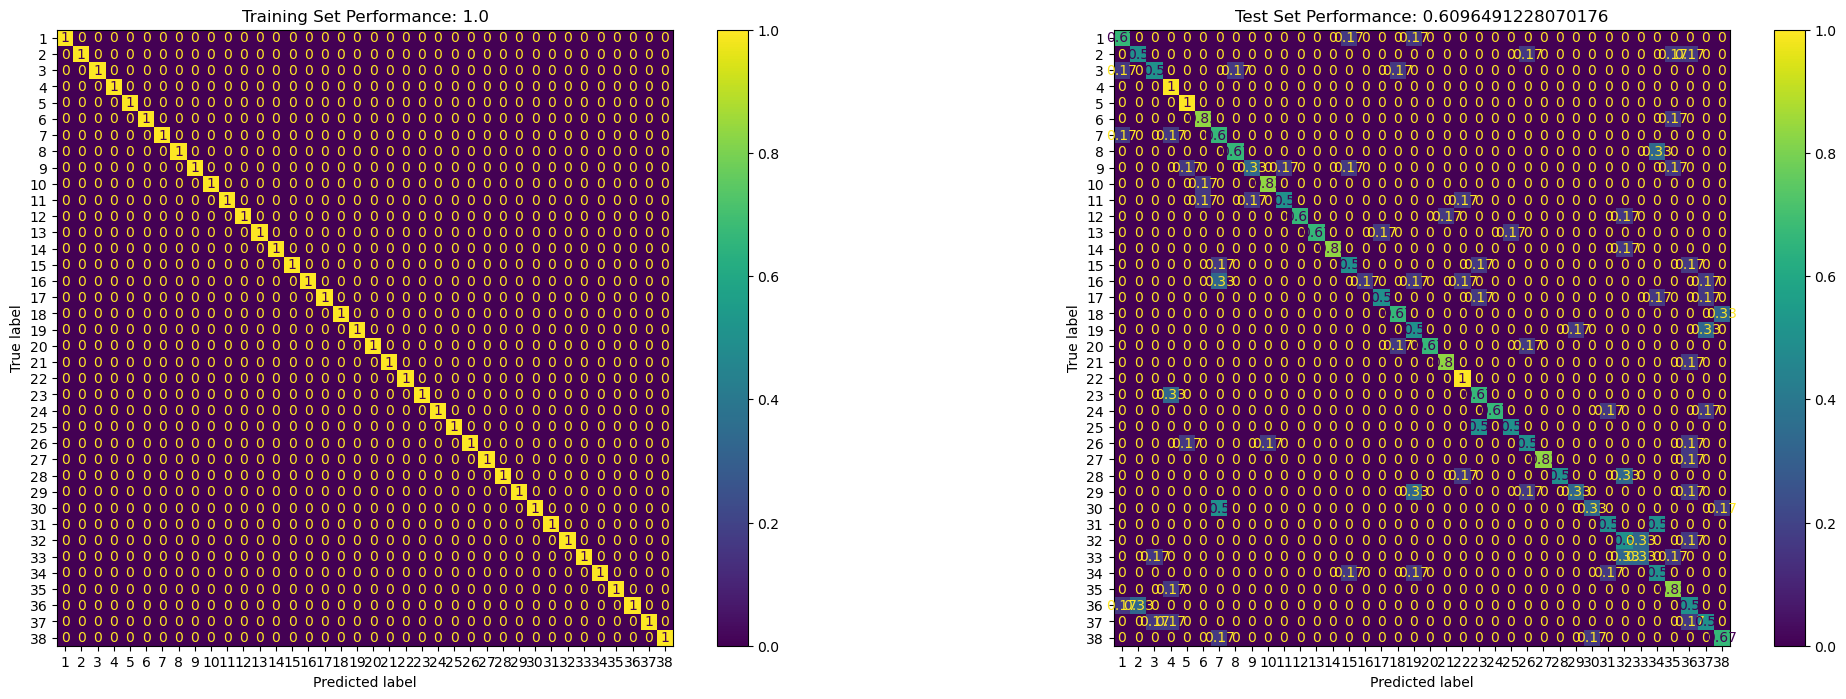

In [32]:
cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));
    
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

### Part 2: ORL Database
First up we'll look at the ORL database. Looking at the labels in the below plot, you can get a sense of how the dataset is structured.

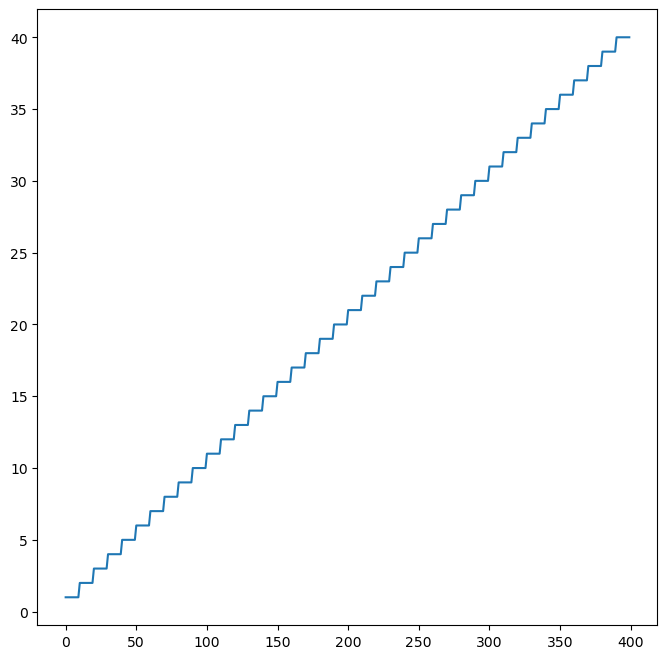

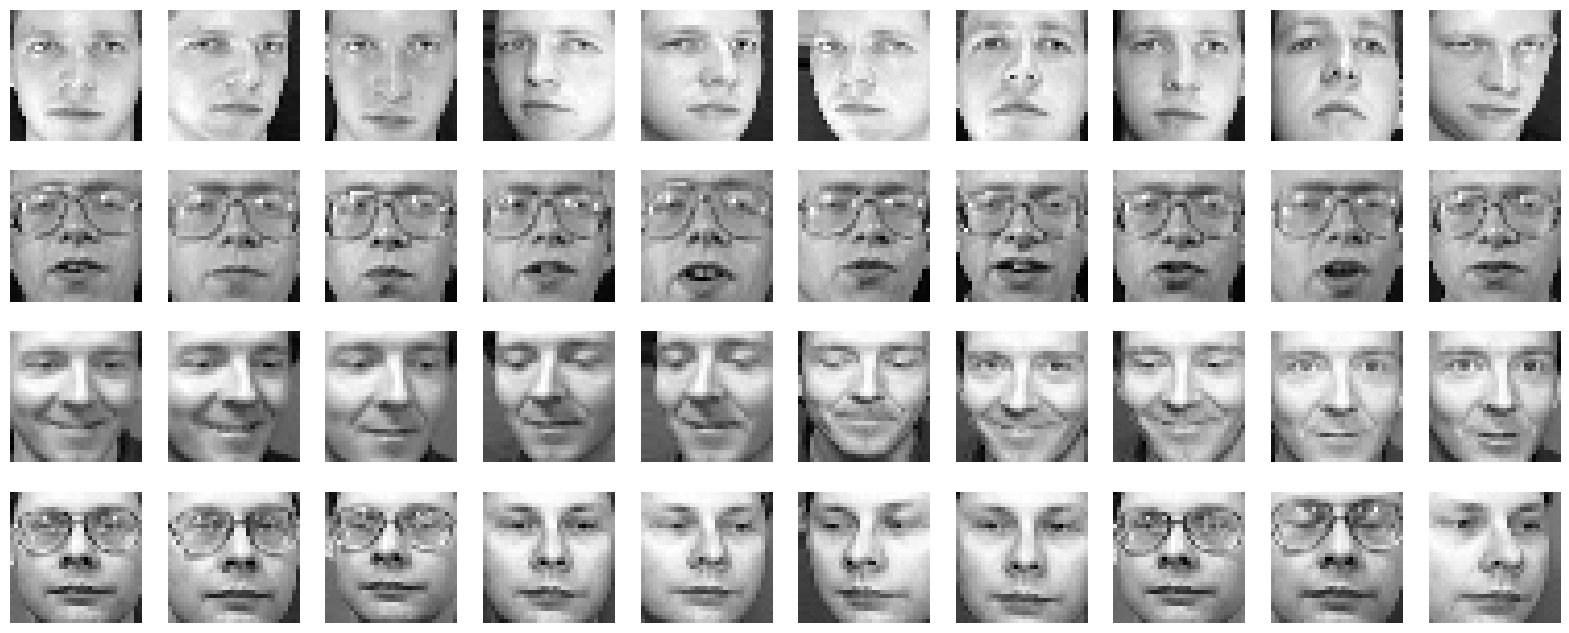

In [35]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(gnd)

faceW = 32
faceH = 32
fea_reshape = numpy.reshape(fea.transpose(), (faceW, faceH, 1, len(fea)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(fea_reshape[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

#### Data Splitting

You now need to split data into train and test. We have 40 subjects, and 10 images per subject. Split the data such that for each subject you have 1-5 images in the test set and the rest in training. 

Explore what happens with different numbers of images in testing and training. Splitting can be based on what is done to split the YaleB dataset.

In [49]:
rng = numpy.random.default_rng(seed = 42)

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = rng.choice(indexes, 5, replace=False)
    test_frames = numpy.append(test_frames, f)

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

#### Apply PCA

Explore classification performance, and reconstruction performance.

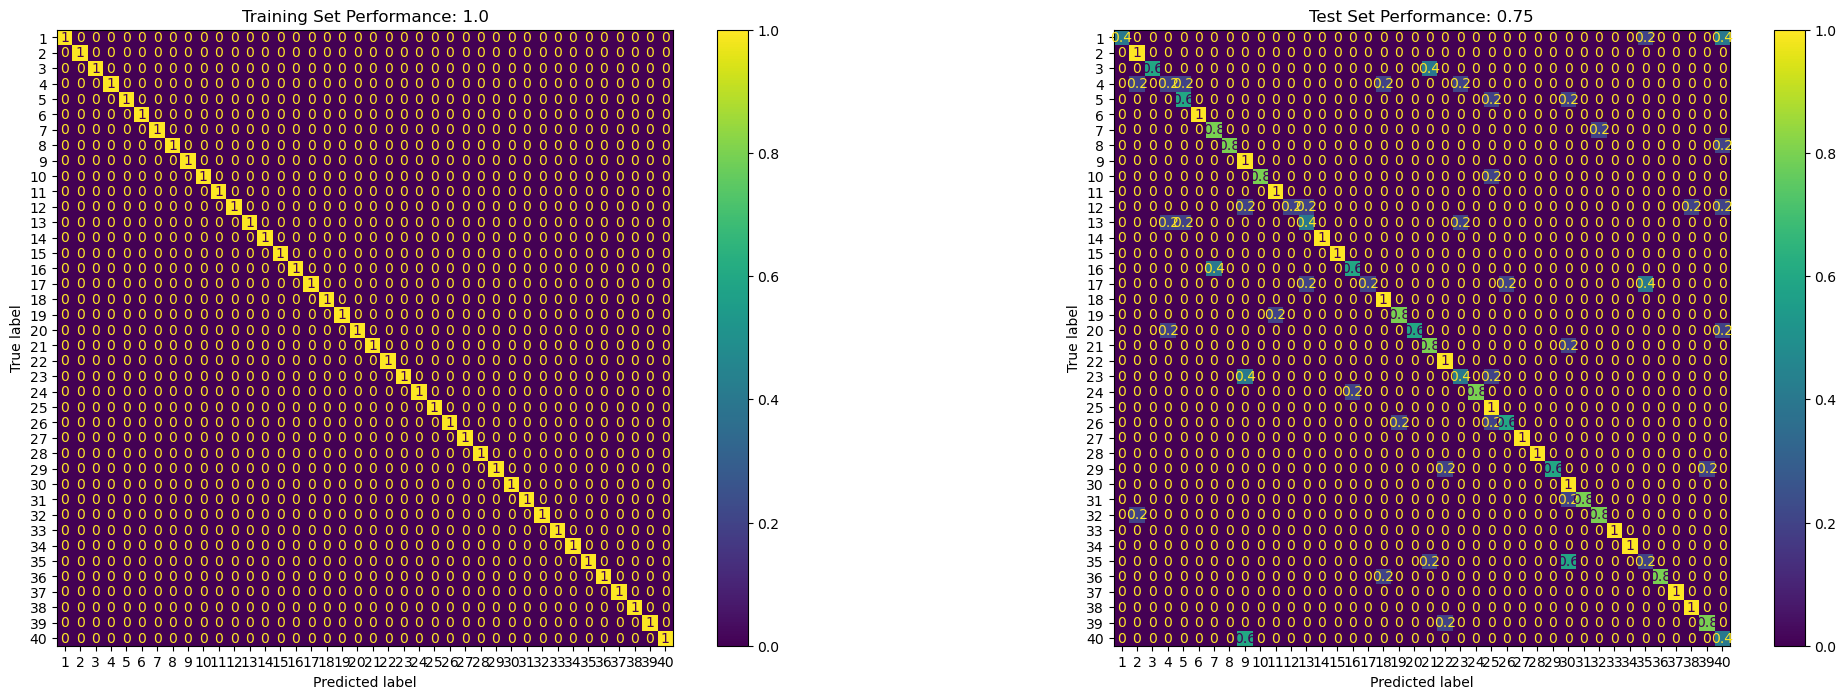

In [50]:
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]
   
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

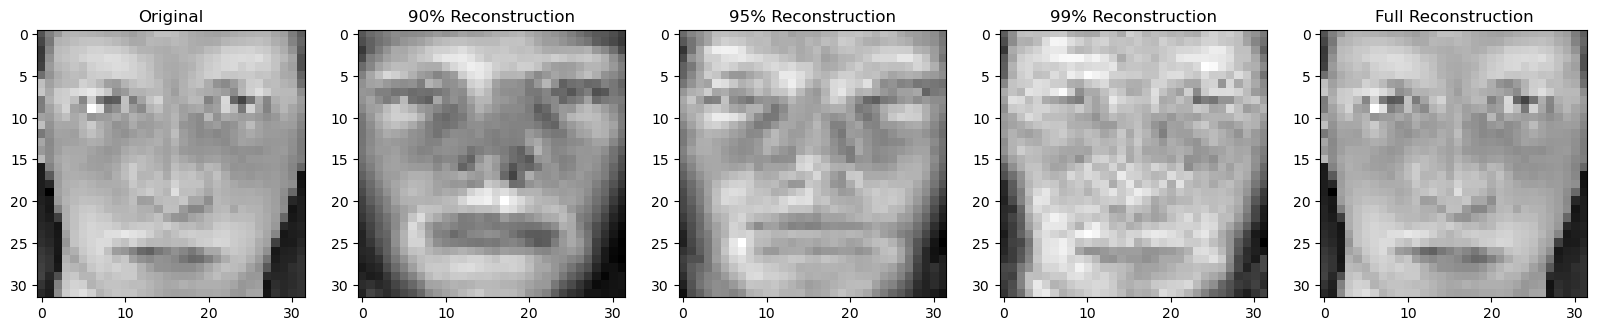

In [54]:
face_id = 1

top90 = 23
top99 = 235

fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 5, 1)
ax.imshow(numpy.reshape(train_fea[face_id,:] - pca.mean_, (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Original');

ax = fig.add_subplot(1, 5, 2)
ax.imshow(numpy.reshape(pca.components_[0:top90,:].transpose().dot(numpy.reshape(transformed[face_id,0:top90], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction');

ax = fig.add_subplot(1, 5, 3)
ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[face_id,0:top95], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction');

ax = fig.add_subplot(1, 5, 4)
ax.imshow(numpy.reshape(pca.components_[0:top99,:].transpose().dot(numpy.reshape(transformed[face_id,0:top99], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction');

ax = fig.add_subplot(1, 5, 5)
ax.imshow(numpy.reshape(pca.components_[:,:].transpose().dot(numpy.reshape(transformed[face_id,:], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction');

### Part 3: Yale Dataset

This is the dataset prior to YaleB, it's much smaller and doesn't have the same level of lighting variation.

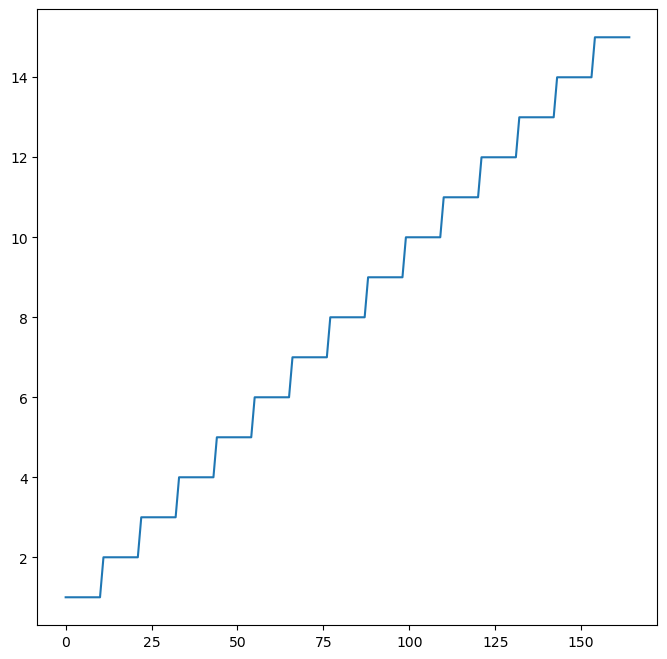

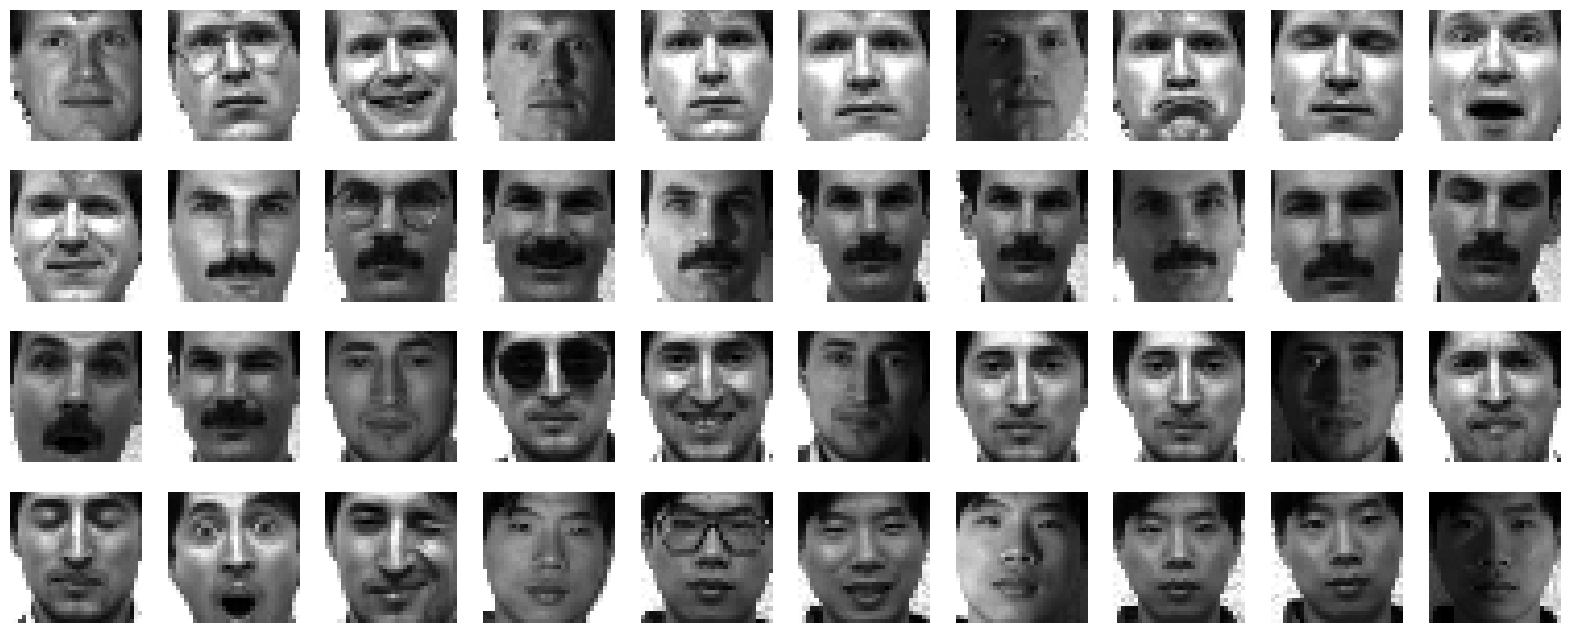

In [58]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(gnd)

faceW = 32
faceH = 32
fea_reshape = numpy.reshape(fea.transpose(), (faceW, faceH, 1, len(fea)))
fig = plt.figure(figsize=[20, 8])
for i in range(40):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(fea_reshape[:,:,0,i].transpose(), cmap=plt.get_cmap('gray'))
    ax.set_axis_off()

#### Data Splitting

Our data has 15 subjects, each with 11 images. Approach this the same as you did ORL.

In [59]:
rng = numpy.random.default_rng(seed = 42)

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = rng.choice(indexes, 5, replace=False)
    test_frames = numpy.append(test_frames, f)

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

#### Apply PCA

Explore classification performance, and reconstruction performance.

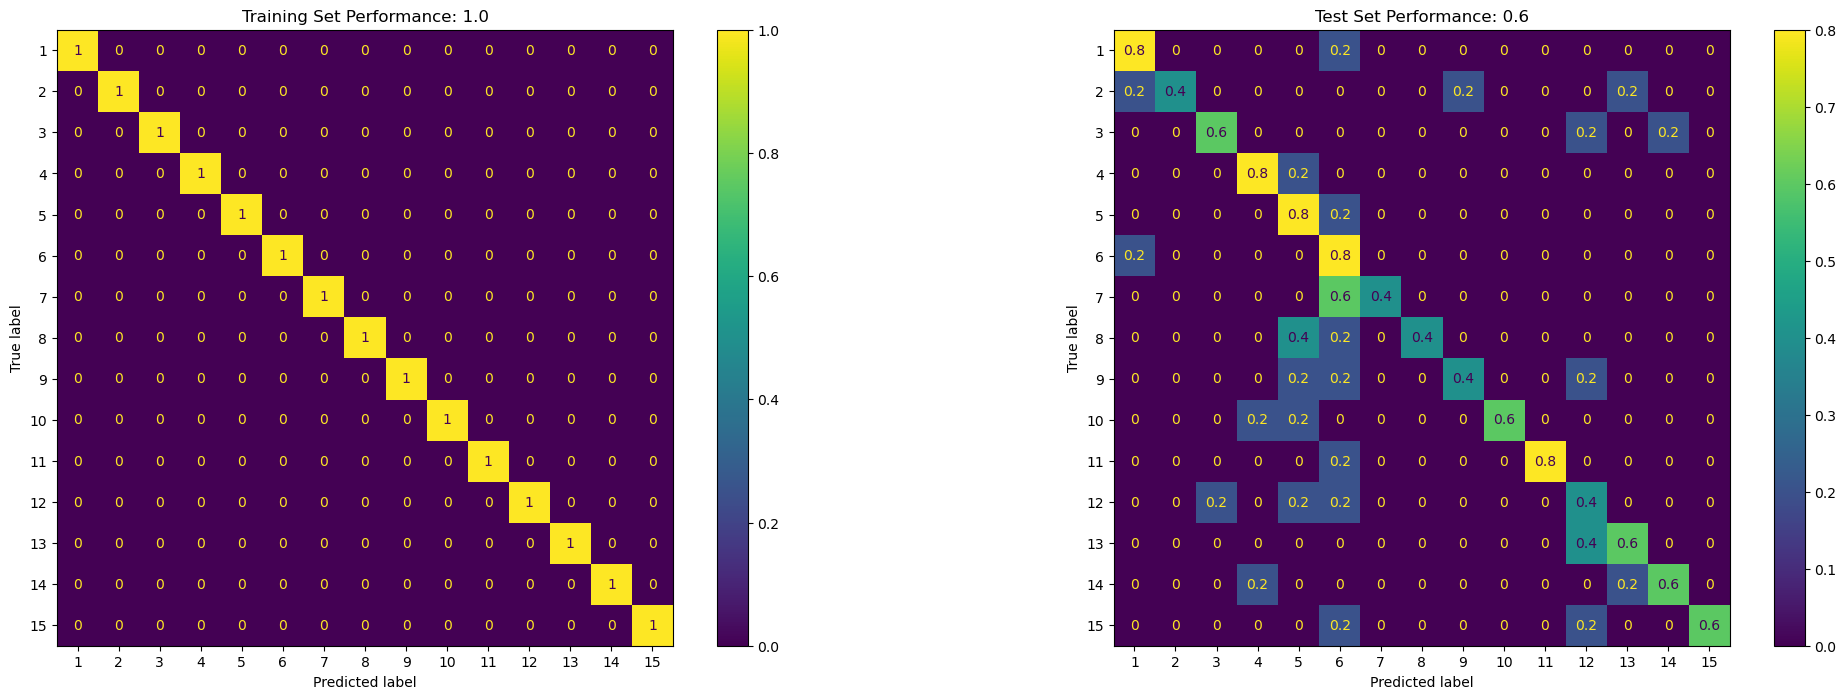

In [60]:
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]
   
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

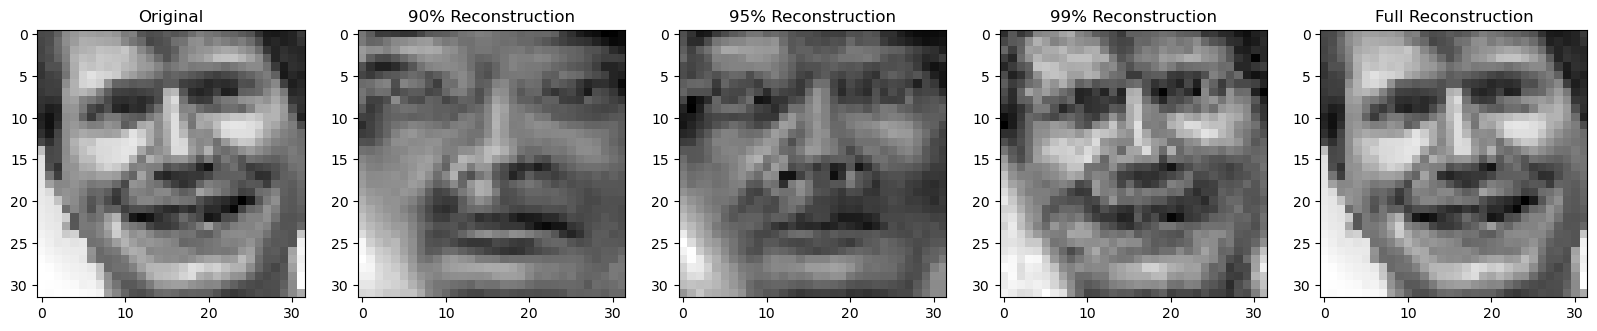

In [61]:
face_id = 1

top90 = 23
top99 = 235

fig = plt.figure(figsize=[20, 5])
ax = fig.add_subplot(1, 5, 1)
ax.imshow(numpy.reshape(train_fea[face_id,:] - pca.mean_, (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Original');

ax = fig.add_subplot(1, 5, 2)
ax.imshow(numpy.reshape(pca.components_[0:top90,:].transpose().dot(numpy.reshape(transformed[face_id,0:top90], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('90% Reconstruction');

ax = fig.add_subplot(1, 5, 3)
ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[face_id,0:top95], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('95% Reconstruction');

ax = fig.add_subplot(1, 5, 4)
ax.imshow(numpy.reshape(pca.components_[0:top99,:].transpose().dot(numpy.reshape(transformed[face_id,0:top99], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('99% Reconstruction');

ax = fig.add_subplot(1, 5, 5)
ax.imshow(numpy.reshape(pca.components_[:,:].transpose().dot(numpy.reshape(transformed[face_id,:], (-1, 1))), (32, 32)).transpose(), cmap=plt.get_cmap('gray'))
ax.set_title('Full Reconstruction');